<a href="https://colab.research.google.com/github/JonathanLoscalzo/pytorch-tutorials/blob/master/Deep%20Learning%20with%20Pytorch/02_transfer_learning_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning: computer vision: 
We alter the architecture
slightly to include a new network block at the end, replacing the standard
1,000-category linear layers that normally perform ImageNet classification.
We then freeze all the existing ResNet layers, and when we train, we update
only the parameters in our new layers, but still take the activations from our
frozen layers. This allows us to quickly train our new layers while
preserving the information that the pretrained layers already contain.

In [0]:
import torch
import torchvision
if torch.cuda.is_available():
  torch.device('cuda')

In [0]:
from tqdm import tqdm

In [0]:
from torch import nn

In [0]:
import numpy as np

In [0]:
import os

In [0]:
from toolz import pipe
from functools import partial
from PIL import Image, ImageFile
from random import randint
import matplotlib.pyplot as plt

In [0]:
from torchvision import models

## Transfer Learning with MobileNetV2

### Gather Data

In [188]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip -d ./

# defining directories
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


--2020-05-27 17:42:43--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 2404:6800:4008:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   210MB/s    in 0.3s    

2020-05-27 17:42:44 (210 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  cats_and_dogs_filtered.zip
replace ./cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./cats_and_dogs_filtered/vectorize.py  
  inflating: ./cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: ./cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: ./cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: ./cats_and

### Preparing Input

In [0]:
# transformations to load images. Always we (or pytorch) need ToTensor. 
# Think that images are (h, w, channels) and torch accepts (channels, h, w)
img_size = 64

img_transforms = torchvision.transforms.Compose([
  torchvision.transforms.Resize((img_size,img_size)),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(
      mean=[0.485, 0.456, 0.406], 
      std=[0.229, 0.224, 0.225] 
  )
])


In [0]:
%%script false --no-raise-error
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# testing with CIFAR10 dataset
mnist_data = torchvision.datasets.CIFAR10('.', train=True, download=True, transform=img_transforms)
mnist_data_test = torchvision.datasets.CIFAR10('.', train=False, transform=img_transforms)

class_names = list(mnist_data.class_to_idx.keys())
num_classes = len(class_names)

train_data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=10, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(mnist_data_test, shuffle=True)
len(train_data_loader) - 1

In [191]:
train_data = torchvision.datasets.ImageFolder(root=train_dir,transform=img_transforms)
val_data = torchvision.datasets.ImageFolder(root=validation_dir, transform=img_transforms)

class_names = list(train_data.class_to_idx.keys())
num_classes = len(class_names)

batch_size=64 # https://pytorch.org/docs/stable/data.html
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
len(train_data_loader), len(val_data_loader)

(32, 16)

In [192]:
transfer_model = models.mobilenet_v2(pretrained=True)
transfer_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

Recall that when initializing optimizer you explicitly tell it what parameters (tensors) of the model it should be updating. The gradients are "stored" by the tensors themselves (they have a grad and a requires_grad attributes) once you call backward() on the loss. After computing the gradients for all tensors in the model, calling optimizer.step() makes the optimizer iterate over all parameters (tensors) it is supposed to update and use their internally stored grad to update their values.

https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step

https://pytorch.org/docs/master/notes/autograd.html


```
for param in model.parameters():
    param.requires_grad = False
```

In [193]:
for name, _ in transfer_model.named_parameters():
  print(name)

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.conv.0.0.weight
features.1.conv.0.1.weight
features.1.conv.0.1.bias
features.1.conv.1.weight
features.1.conv.2.weight
features.1.conv.2.bias
features.2.conv.0.0.weight
features.2.conv.0.1.weight
features.2.conv.0.1.bias
features.2.conv.1.0.weight
features.2.conv.1.1.weight
features.2.conv.1.1.bias
features.2.conv.2.weight
features.2.conv.3.weight
features.2.conv.3.bias
features.3.conv.0.0.weight
features.3.conv.0.1.weight
features.3.conv.0.1.bias
features.3.conv.1.0.weight
features.3.conv.1.1.weight
features.3.conv.1.1.bias
features.3.conv.2.weight
features.3.conv.3.weight
features.3.conv.3.bias
features.4.conv.0.0.weight
features.4.conv.0.1.weight
features.4.conv.0.1.bias
features.4.conv.1.0.weight
features.4.conv.1.1.weight
features.4.conv.1.1.bias
features.4.conv.2.weight
features.4.conv.3.weight
features.4.conv.3.bias
features.5.conv.0.0.weight
features.5.conv.0.1.weight
features.5.conv.0.1.bias
features.5.conv.1.

In [194]:
for name, _ in transfer_model.named_modules():
  print(name)


features
features.0
features.0.0
features.0.1
features.0.2
features.1
features.1.conv
features.1.conv.0
features.1.conv.0.0
features.1.conv.0.1
features.1.conv.0.2
features.1.conv.1
features.1.conv.2
features.2
features.2.conv
features.2.conv.0
features.2.conv.0.0
features.2.conv.0.1
features.2.conv.0.2
features.2.conv.1
features.2.conv.1.0
features.2.conv.1.1
features.2.conv.1.2
features.2.conv.2
features.2.conv.3
features.3
features.3.conv
features.3.conv.0
features.3.conv.0.0
features.3.conv.0.1
features.3.conv.0.2
features.3.conv.1
features.3.conv.1.0
features.3.conv.1.1
features.3.conv.1.2
features.3.conv.2
features.3.conv.3
features.4
features.4.conv
features.4.conv.0
features.4.conv.0.0
features.4.conv.0.1
features.4.conv.0.2
features.4.conv.1
features.4.conv.1.0
features.4.conv.1.1
features.4.conv.1.2
features.4.conv.2
features.4.conv.3
features.5
features.5.conv
features.5.conv.0
features.5.conv.0.0
features.5.conv.0.1
features.5.conv.0.2
features.5.conv.1
features.5.conv.1.0

In [0]:
# freeze parameters
for name, param in transfer_model.named_parameters():
  param.requires_grad = False

In [196]:
# Replace head: our classifier
transfer_model.classifier = nn.Sequential(
  nn.Linear(transfer_model.classifier[1].in_features, 500),
  nn.ReLU(),
  nn.Dropout(0.2), 
  nn.Linear(500,num_classes)
)

transfer_model.classifier

Sequential(
  (0): Linear(in_features=1280, out_features=500, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=500, out_features=2, bias=True)
)

In [0]:
# calculate gradients
loss_fn = torch.nn.CrossEntropyLoss()

# update parameters by optimizer
optimizer = torch.optim.Adam(transfer_model.parameters(), lr=0.001)

model = transfer_model

In [0]:
def train_one_epoch(model, inputs, targets, loss_fn, optimizer):
    optimizer.zero_grad()
    output = model(inputs)
    loss = loss_fn(output, targets)
    loss.backward()
    optimizer.step()
    return loss

def eval_one_epoch(model, inputs, targets, loss_fn):
    output = model(inputs)
    loss_val = loss_fn(output,targets) 
    max_idxs = torch.functional.F.softmax(output, dim=1).argmax(dim=1) # 
    correct = torch.eq(max_idxs, targets)
    return loss_val, correct

In [0]:
%%script false --no-raise-error
epochs=5

for epoch in range(epochs):
  # model.train()
  training_loss = 0

  for batch in tqdm(train_data_loader):
    inputs, targets = batch
    loss = train_one_epoch(model, inputs, targets, loss_fn, optimizer)
    training_loss += loss.item() * inputs.size(0)
  
  training_loss /= len(train_data_loader.dataset)
  # model.eval()

  num_correct = 0
  num_examples = 0
  valid_loss = 0

  for batch in tqdm(val_data_loader):
    inputs, targets = batch
    loss_val, correct = eval_one_epoch(model, inputs, targets, loss_fn)
    valid_loss += loss_val.data.item() * inputs.size(0)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]

  valid_loss /= len(val_data_loader.dataset)

  print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(
      epoch, 
      training_loss, 
      valid_loss, 
      num_correct / num_examples
  ))

In [0]:
%%script false --no-raise-error
labels = list(train_data.class_to_idx.keys())

model.eval()

to_evaluate = [validation_dir+f'/dogs/dog.{randint(2000,2499)}.jpg', validation_dir+f"/cats/cat.{randint(2000,2499)}.jpg"]

for ix, file in enumerate(to_evaluate):
  img = Image.open(file) 
  prediction = pipe(
      img, 
      img_transforms,
      partial(torch.reshape, shape=(-1,3,64,64)),
      model,
      torch.functional.F.softmax
  )
  prediction = prediction.argmax()
  plt.figure()
  plt.imshow(img)
  plt.title(labels[prediction])

## Learning Aspects

### Avoiding grid_search for optimizer step / Finding learning rate

Over the course of an epoch, start out with a small learning rate and
increase to a higher learning rate over each mini-batch, resulting in a high rate at the end of the epoch. Calculate the loss for each rate and then, looking at a plot, pick the learning rate that gives the greatest decline.

see: “Cyclical Learning Rates for Training Neural Networks” by Leslie Smith (2015). or Jeremy Howard at fast.ai

> Note that you’re not looking for the bottom of the curve, which might be the more intuitive place; you’re looking for the point that is getting to the bottom the fastest.

In [201]:
optimizer.param_groups[0]['lr']

0.001

In [0]:
transfer_model = models.mobilenet_v2(pretrained=True)

# freeze parameters
# https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/2
for name, param in transfer_model.named_parameters():
  param.requires_grad = False

# Replace head: our classifier
transfer_model.classifier = nn.Sequential(
  nn.Linear(transfer_model.classifier[1].in_features, 500),
  nn.ReLU(),
  nn.Dropout(0.2), 
  nn.Linear(500, num_classes)
)

In [0]:
# finding learning rate
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0):
    
    def _crashout(log_lrs, losses):
      # if (len(log_lrs) > 20):
          # return log_lrs[10:-5], losses[10:-5]
      # else:
          return log_lrs, losses

    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)

    print("Batches:", number_in_epoch, " Update Step: ", update_step)

    lr = init_value
    optimizer.param_groups[0]["lr"] = lr

    # Note that you’re not looking for the bottom of the curve, which might be the more
    # intuitive place; you’re looking for the point that is getting to the bottom the fastest.
    best_batch = 0
    best_loss = torch.tensor(0.0)
    batch_num = 0

    losses = []
    log_lrs = []

    for data in train_loader:
        batch_num += 1
        inputs, targets = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes        
        if batch_num > 1 and loss > 4 * best_loss:
            return _crashout(log_lrs, losses), best_loss, best_batch

        # Record the best loss
        if loss < best_loss or batch_num == 1:
            best_loss = loss
            best_batch = batch_num

        print("Batch: {}, Loss: {}, Best Loss:{}".format(batch_num, loss.item(), best_loss.item()))

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr

    return _crashout(log_lrs, losses), best_loss, best_batch


In [0]:
optimizer = torch.optim.Adam(transfer_model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

model = transfer_model

In [205]:
(logs, losses), best_loss, best_batch= find_lr(model, loss_fn, optimizer, train_data_loader)

Batches: 31  Update Step:  1.9512934226359633
Batch: 1, Loss: 0.7404916286468506, Best Loss:0.7404916286468506
Batch: 2, Loss: 0.691641092300415, Best Loss:0.691641092300415
Batch: 3, Loss: 0.753521740436554, Best Loss:0.691641092300415
Batch: 4, Loss: 0.7011345028877258, Best Loss:0.691641092300415
Batch: 5, Loss: 0.7305112481117249, Best Loss:0.691641092300415
Batch: 6, Loss: 0.7240234017372131, Best Loss:0.691641092300415
Batch: 7, Loss: 0.7439980506896973, Best Loss:0.691641092300415
Batch: 8, Loss: 0.7389345169067383, Best Loss:0.691641092300415
Batch: 9, Loss: 0.7018803358078003, Best Loss:0.691641092300415
Batch: 10, Loss: 0.7320485711097717, Best Loss:0.691641092300415
Batch: 11, Loss: 0.7510559558868408, Best Loss:0.691641092300415
Batch: 12, Loss: 0.7109546065330505, Best Loss:0.691641092300415
Batch: 13, Loss: 0.7073020339012146, Best Loss:0.691641092300415
Batch: 14, Loss: 0.7157789468765259, Best Loss:0.691641092300415
Batch: 15, Loss: 0.669051468372345, Best Loss:0.669051

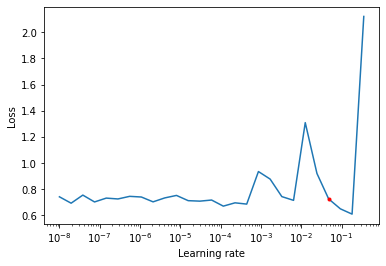

0.047579443140094 0.7242239713668823 23


0.047579443140094

In [206]:
before = best_batch-3
plt.plot(logs, losses)
plt.plot([logs[before]], [losses[before]], marker='o', markersize=3, color="red")
plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

print(logs[before], losses[before], before)
found_lr = logs[before] #1e-2
found_lr


Finally, remember that because this function does actually train the
model and dirty with the optimizer’s learning rate settings, you should save and reload your model beforehand to get back to the state it was in before you called find_lr() and also reinitialize the optimizer you’ve chosen

---



In mobilenet case these layers are: 

Note: see names with ```model.named_modules()```


### Differential Learning Rates

Training different groups of layers at different rates.


```
optimizer = optimizer.Adam([
{ 'params': transfer_model.layer4.parameters(), 'lr': found_lr /3},
{ 'params': transfer_model.layer3.parameters(), 'lr': found_lr /9},
], lr=found_lr)
```

Then unfreeze these layers: 
```
unfreeze_layers = [transfer_model.layer3, transfer_model.layer4]
for layer in unfreeze_layers:
  for param in layer.parameters():
    param.requires_grad = True
```


In [0]:
transfer_model = models.mobilenet_v2(pretrained=True)

for name, param in transfer_model.named_parameters():
  param.requires_grad = False

transfer_model.classifier = nn.Sequential(
  nn.Linear(transfer_model.classifier[1].in_features, 500),
  nn.ReLU(),
  nn.Dropout(0.2), 
  nn.Linear(500, num_classes)
)

model = transfer_model


In [208]:
for layer in [model.features[17], model.features[18]]:
  for name, param in layer.named_parameters():
    print("Parameter: {}, Requires Grads: {}".format(name, param.requires_grad))
    param.requires_grad = True

Parameter: conv.0.0.weight, Requires Grads: False
Parameter: conv.0.1.weight, Requires Grads: False
Parameter: conv.0.1.bias, Requires Grads: False
Parameter: conv.1.0.weight, Requires Grads: False
Parameter: conv.1.1.weight, Requires Grads: False
Parameter: conv.1.1.bias, Requires Grads: False
Parameter: conv.2.weight, Requires Grads: False
Parameter: conv.3.weight, Requires Grads: False
Parameter: conv.3.bias, Requires Grads: False
Parameter: 0.weight, Requires Grads: False
Parameter: 1.weight, Requires Grads: False
Parameter: 1.bias, Requires Grads: False


In [0]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
  { 'params': model.features[17].parameters(), 'lr': found_lr / 9 },
  { 'params': model.features[18].parameters(), 'lr': found_lr / 3 },
], lr=found_lr)

In [0]:
update_gradients = [ param.requires_grad for param in model.parameters()]

In [211]:
model.training

True

In [0]:
# from torchsummary import summary
# summary(model, (3, 64, 64), device='cpu') # change to cuda according to the device you are using

Note that you can freeze and unfreeze parts of the model at will and do fine-tuning on each selected layer. Like [here](https://github.com/ultralytics/yolov3/wiki/Example:-Train-Single-Class#reproduce-our-results)

In [213]:
epochs=5

for epoch in range(epochs):
  # model.train()
  training_loss = 0

  for batch in tqdm(train_data_loader):
    inputs, targets = batch
    loss = train_one_epoch(model, inputs, targets, loss_fn, optimizer)
    training_loss += loss.item() * inputs.size(0)
  
  training_loss /= len(train_data_loader.dataset)
  
  #model.eval()
  num_correct = 0
  num_examples = 0
  valid_loss = 0

  for batch in tqdm(val_data_loader):
    with torch.no_grad():
      inputs, targets = batch
      loss_val, correct = eval_one_epoch(model, inputs, targets, loss_fn)

    valid_loss += loss_val.data.item() * inputs.size(0)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]

  valid_loss /= len(val_data_loader.dataset)

  print('\nEpoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(
      epoch, 
      training_loss, 
      valid_loss, 
      num_correct / num_examples
  ))

  0%|          | 0/32 [00:00<?, ?it/s]


Epoch: 0, Training Loss: 0.55, Validation Loss: 1.13, accuracy = 0.51


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch: 1, Training Loss: 0.36, Validation Loss: 1.43, accuracy = 0.49


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch: 2, Training Loss: 0.29, Validation Loss: 1.61, accuracy = 0.50


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch: 3, Training Loss: 0.23, Validation Loss: 1.84, accuracy = 0.50


100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


Epoch: 4, Training Loss: 0.18, Validation Loss: 2.00, accuracy = 0.51


>figure out: BatchNormalization trainable or not?

## Data Aspects
If we see last training, it seems overfitted. How to deal with overfitting in case of we couln't gather more images?

### Data Augmentation
Torchivision.transforms library
contains many other transformation functions that can be used to augment
training data.
Another Library is [Albumentations](https://github.com/albumentations-team/albumentations)



In [0]:
# selecting 2 images:


def get_random_images():
  return [
    train_dir+f'/dogs/dog.{randint(100,1000)}.jpg', 
    train_dir+f"/cats/cat.{randint(100,1000)}.jpg"
  ]

to_evaluate = get_random_images()

common_transforms = torchvision.transforms.Compose([
  torchvision.transforms.Resize((128,128)),
  torchvision.transforms.ToTensor(),
  # torchvision.transforms.Normalize(
  #     mean=[0.485, 0.456, 0.406], 
  #     std=[0.229, 0.224, 0.225] 
  # )
])

In [0]:
def show_transformation_in_action(transformations):
  fig, subplots = plt.subplots(2,2, figsize=(10,10))
  to_evaluate = get_random_images()
  for ix, file in enumerate(to_evaluate):
    img = Image.open(file)

    img1 = common_transforms(img)
    img2 = transformations(img)

    subplots[ix][0].imshow(img1.permute(1,2,0))
    subplots[ix][1].imshow(img2.permute(1,2,0))

#### ColorJitter
randomly changes the brightness,  contrast, saturation, and hue (matiz) of an image.
- [max(0, 1 - brightness), 1 + brightness]
- [max(0, 1 - contrast), 1 + contrast]
- [max(0, 1 - saturation), 1 + saturation]
- [-hue_min, hue_max] hue_min and max could be 0.5 (or negative)

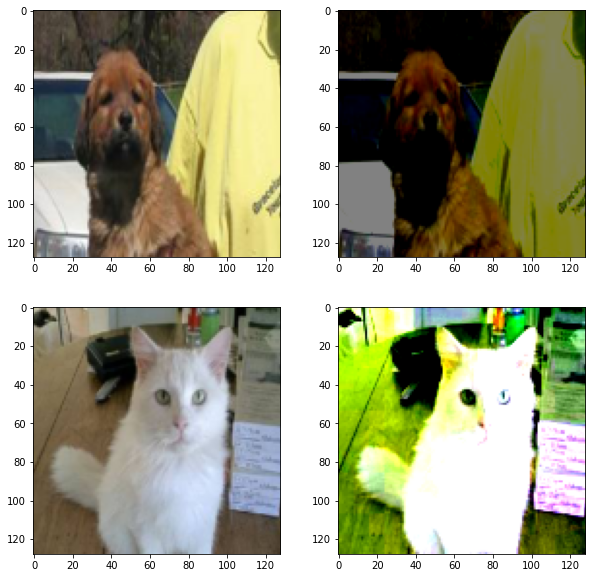

In [216]:
colorjitter_transforms =  torchvision.transforms.Compose([
  torchvision.transforms.Resize((128,128)),
  torchvision.transforms.ColorJitter(
      brightness=[0,2], 
      contrast=[2,3], 
      saturation=1,
      hue=[-0.1, 0.1]
  ),
  torchvision.transforms.ToTensor(),
])

show_transformation_in_action(colorjitter_transforms)

#### Flip
p: supply a float from 0 to 1 for the probability of the reflection to occur.

we set 1  to see how changes.

In [0]:
flip_horizontal_transforms =  torchvision.transforms.Compose([
  torchvision.transforms.Resize((128,128)),
  torchvision.transforms.RandomHorizontalFlip(p=1),
  torchvision.transforms.ToTensor(),
])

flip_vertical_transforms =  torchvision.transforms.Compose([
  torchvision.transforms.Resize((128,128)),
  torchvision.transforms.RandomVerticalFlip(p=1),
  torchvision.transforms.ToTensor(),
])

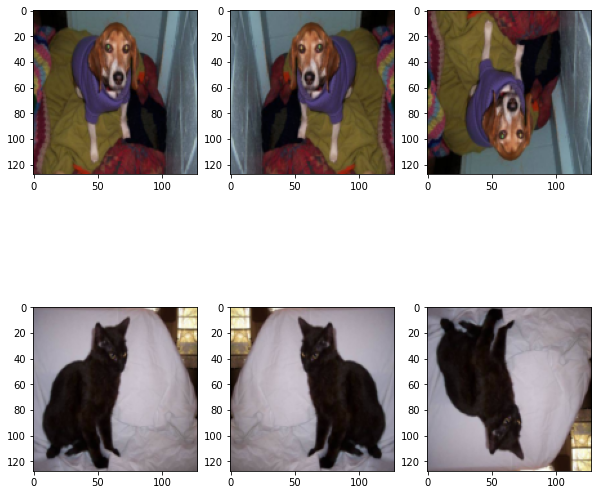

In [218]:
fig, subplots = plt.subplots(2,3, figsize=(10,10))
to_evaluate = get_random_images()
for ix, file in enumerate(to_evaluate):
  img = Image.open(file)

  img1 = common_transforms(img)
  img2 = flip_horizontal_transforms(img)
  img3 = flip_vertical_transforms(img)

  subplots[ix][0].imshow(img1.permute(1,2,0))
  subplots[ix][1].imshow(img2.permute(1,2,0))
  subplots[ix][2].imshow(img3.permute(1,2,0))


#### RandomGrayscale
Turn image in grayscale by probability *p*.

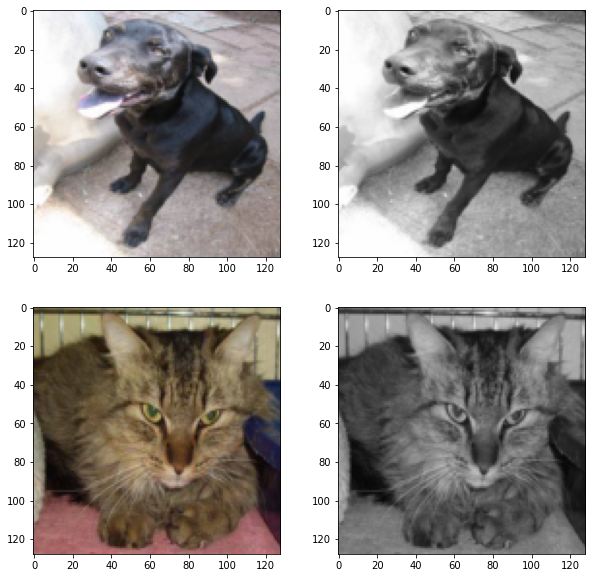

In [219]:
grayscale_transform =  torchvision.transforms.Compose([
  torchvision.transforms.Resize((128,128)),
  torchvision.transforms.RandomGrayscale(p=1),
  torchvision.transforms.ToTensor(),
])

show_transformation_in_action(grayscale_transform)

#### Cropping
[RandomCrop](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomCrop) and [RandomResizeCrop](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomResizedCrop) , as you might expect, perform random crops on the image of size , which can either be an int for height and width, or a tuple containing different heights and widths. shows an example of a RandomCrop in action.

While the RandomResizeCrop will resize the crop to fill the given size, RandomCrop may take a crop close to the edge and into the darkness beyond the image.

See cropping in action.

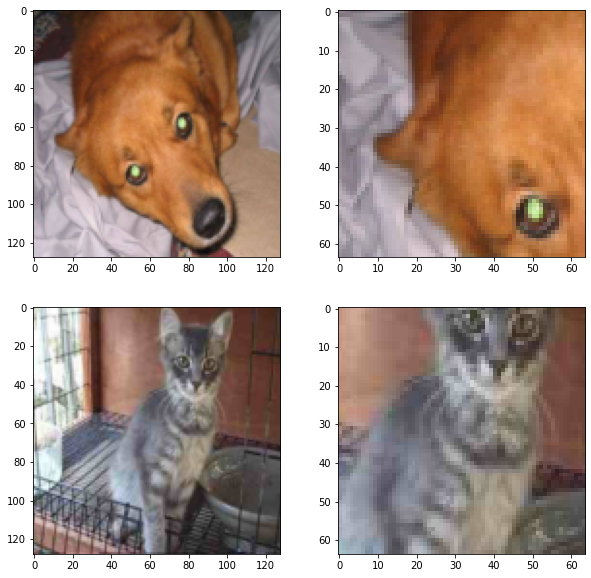

In [220]:
randomcrop_transform =  torchvision.transforms.Compose([
  torchvision.transforms.Resize((128,128)),
  torchvision.transforms.RandomCrop(
      size=64, 
      padding=None, 
      pad_if_needed=False, 
      fill=0, 
      padding_mode='constant'
  ),
  torchvision.transforms.ToTensor(),
])

show_transformation_in_action(randomcrop_transform)

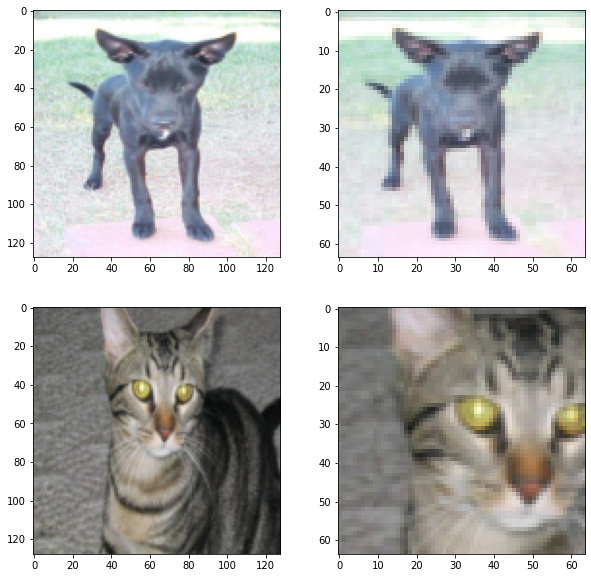

In [221]:
random_resizedcrop_transform =  torchvision.transforms.Compose([
  torchvision.transforms.Resize((128,128)),
  torchvision.transforms.RandomResizedCrop(
      size=64, 
      scale=(0.08, 1.0),
      ratio=(0.75, 1.3333333333333333), 
      interpolation=2
  ),
  torchvision.transforms.ToTensor(),
])

show_transformation_in_action(random_resizedcrop_transform)

#### Rotation


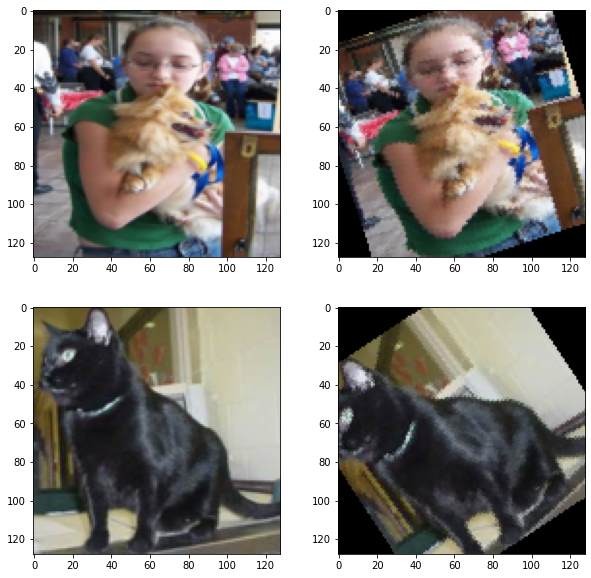

In [222]:
rotation_transform =  torchvision.transforms.Compose([
  torchvision.transforms.Resize((128,128)),
  torchvision.transforms.RandomRotation(
      degrees=[-45, 45], 
      resample=False,
      expand=False, # rotate and hold the entire image
      center=None, # optional center of rotation
    ),
  torchvision.transforms.ToTensor(),
])

show_transformation_in_action(rotation_transform)

#### [Pad](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Pad)

Pad the given PIL Image on all sides with the given “pad” value.
- padding: extra height and width

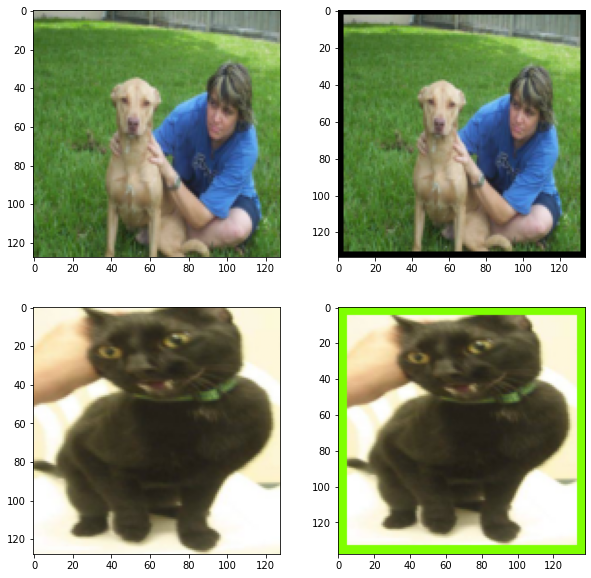

In [223]:

# setting pad to reflect
pad_transform =  torchvision.transforms.Compose([
  torchvision.transforms.Resize((128,128)),
  torchvision.transforms.RandomChoice([
    torchvision.transforms.Pad(padding=3, fill=0, padding_mode='constant'),
    torchvision.transforms.Pad(padding=10, fill=0, padding_mode='constant'),
    torchvision.transforms.Pad(padding=5, fill=(127,255,0), padding_mode='constant'),
    torchvision.transforms.Pad(padding=25, padding_mode='reflect'),
  ]),
  torchvision.transforms.ToTensor(),
])

show_transformation_in_action(pad_transform)

#### Lambda or user-defined transformations

See:
- HSV model [here](https://es.wikipedia.org/wiki/Modelo_de_color_HSV). Hue, Saturation, Value
- RGB model: Red Green Blue

We will build to_hsv, a function which implements [these transformations](https://es.wikipedia.org/wiki/Modelo_de_color_HSV#Transformaci%C3%B3n_RGB_a_HSV)


> Think: Why? a dog is a dog whatever the color.


In [0]:
def to_hsv(x):
  output = x.convert("HSV")
  return output

colour_transform = torchvision.transforms.Lambda(lambda x: to_hsv(x))


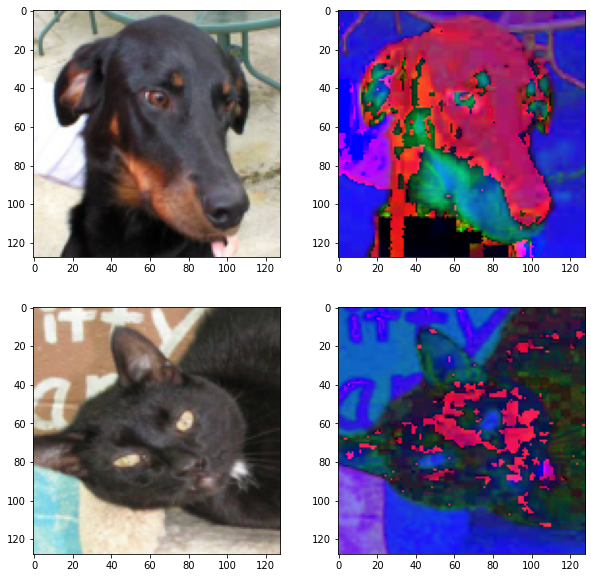

In [225]:

# setting pad to reflect
pad_transform =  torchvision.transforms.Compose([
  torchvision.transforms.Resize((128,128)),
  colour_transform,
  torchvision.transforms.ToTensor(),
])

show_transformation_in_action(pad_transform)

Another option could be create a custom transformation by class. This transform haven't any restrictions ( there should be an interface... at least for __call__ method).

So you could make play with any transformation whilst you return a tensor :) 

See [functional_transforms](https://pytorch.org/docs/stable/torchvision/transforms.html#functional-transforms) to execute torch transformations as functions

In [0]:
class CustomTransformation():
  def __init__(self, *args, **kwargs):
    # define some internal state here
    pass

  def __call__(self, tensor):
    # is invoking during the transformation pipeline
    return tensor

  def __repr__(self):
    repr = f"{self.__class__.__name__}"
    return repr

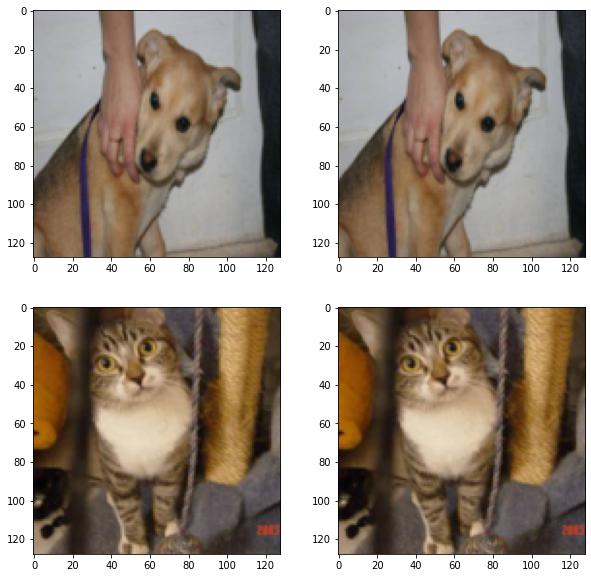

In [227]:
# setting pad to reflect
pad_transform =  torchvision.transforms.Compose([
  torchvision.transforms.Resize((128,128)),
  CustomTransformation(10,20, some_named_param='whatever'),
  torchvision.transforms.ToTensor(),
])

show_transformation_in_action(pad_transform)